In [ ]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import re
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# 2. LOAD DATA
df = pd.read_csv("/content/Ola Customer Reviews.csv")
df = df[["review_description", "rating","thumbs_up"]].dropna()

print("Dataset loaded with", len(df), "reviews")

C:\Users\Devarshi\AppData\Local\Temp\ipykernel_1772\2310875986.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:\jupyter\DataSets\Ola Customer Reviews.csv")


Dataset loaded with 356787 reviews


<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

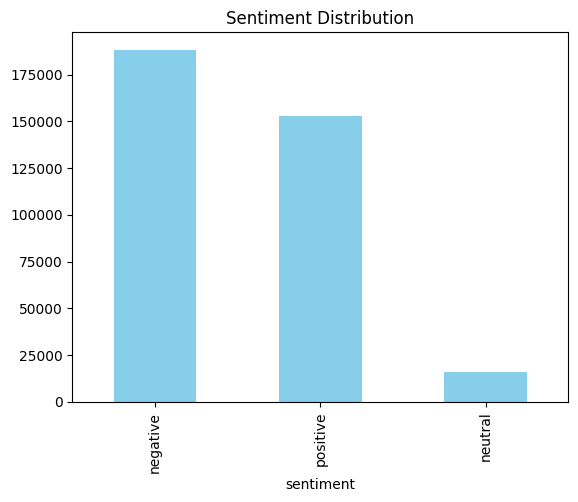

In [ ]:
# 3. MAP RATINGS TO SENTIMENT LABELS
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment"] = df["rating"].apply(map_rating_to_sentiment)

# Balance the dataset
df["sentiment"].value_counts().plot(kind='bar', title="Sentiment Distribution", color="skyblue")

In [ ]:
# 4. CLEAN TEXT
def clean_text(text):
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.strip().lower()

df["cleaned"] = df["review_description"].apply(clean_text)

In [ ]:
# 5. ASPECT EXTRACTION USING SPACY
nlp = spacy.load("en_core_web_sm")

# def extract_aspects(text):
#     doc = nlp(text)
#     return [chunk.text.lower() for chunk in doc.noun_chunks if len(chunk.text.strip()) > 1]

def batch_extract_aspects(texts, batch_size=1000):
    aspects = []
    for doc in nlp.pipe(texts, batch_size=batch_size, disable=["ner", "textcat"]):
        chunks = [chunk.text.lower() for chunk in doc.noun_chunks if len(chunk.text.strip()) > 1]
        aspects.append(chunks)
    return aspects

# df["aspects"] = df["cleaned"].apply(extract_aspects)
df["aspects"] = batch_extract_aspects(df["cleaned"])

In [ ]:
# 6. MODEL TRAINING (TF-IDF + LOGISTIC REGRESSION WITH WEIGHTING)

# Fill missing values in thumbs_up with 0
df["thumbs_up"] = df["thumbs_up"].fillna(0)

# Normalize thumbs_up to avoid extreme weights
# (Optional tweak: log scale to reduce extreme gaps)
df["weight"] = df["thumbs_up"].apply(lambda x: np.log1p(x))  # log1p(x) = log(1 + x)

# TF-IDF Vectorization
X = df["cleaned"]
y = df["sentiment"]
X_vec = vectorizer.fit_transform(X)

# Split data
X_train_vec, X_test_vec, y_train, y_test, w_train, w_test = train_test_split(
    X_vec, y, df["weight"], test_size=0.2, random_state=42
)

# Train with sample weights
model = LogisticRegression(max_iter=200)
model.fit(X_train_vec, y_train, sample_weight=w_train)

In [ ]:
# 7. EVALUATION
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# 8. ABSA: FILTER REVIEWS CONTAINING AN ASPECT & PREDICT SENTIMENT
def absa_analysis(aspect_term, sample_total=10):
    filtered = df[df["cleaned"].str.contains(aspect_term.lower(), na=False)].copy()
    if len(filtered) == 0:
        print("No reviews found for aspect:", aspect_term)
        return

    # Predict sentiment for filtered reviews
    X_filtered = vectorizer.transform(filtered["cleaned"])
    filtered["predicted_sentiment"] = model.predict(X_filtered)

    # Display sentiment breakdown
    counts = filtered["predicted_sentiment"].value_counts(normalize=True) * 100
    print(f"\nSentiment distribution for aspect '{aspect_term}':\n")
    print(counts.round(2).to_string())

    # Sample reviews
    print(f"\nSample Reviews for aspect '{aspect_term}':\n")
    sample_counts = {
        label: round(sample_total * (counts.get(label, 0) / 100))
        for label in ["positive", "neutral", "negative"]
    }

    # Adjust sample total
    while sum(sample_counts.values()) > sample_total:
        for label in sample_counts:
            if sample_counts[label] > 0:
                sample_counts[label] -= 1
                break
    while sum(sample_counts.values()) < sample_total:
        for label in sample_counts:
            sample_counts[label] += 1
            if sum(sample_counts.values()) == sample_total:
                break

    for sentiment, count in sample_counts.items():
        samples = filtered[filtered["predicted_sentiment"] == sentiment].sample(n=min(count, len(filtered[filtered["predicted_sentiment"] == sentiment])), random_state=42)
        for review in samples["review_description"]:
            print(f"[{sentiment.upper()}] {review}\n")


In [ ]:
# 9. TEST ABSA
absa_analysis("driver", sample_total=10)
absa_analysis("payment", sample_total=10)
absa_analysis("app", sample_total=10)